# Regression Trees

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz 
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from data_cleaning import clean_car_data

## Data Prep

,price,mileage,color,region,age,is_f-150
9,5250,63418,1,2,3,0
18,5210,35714,0,2,3,0
23,6180,46010,5,2,3,0
33,5330,37792,6,2,3,0
38,7320,32366,6,2,3,0


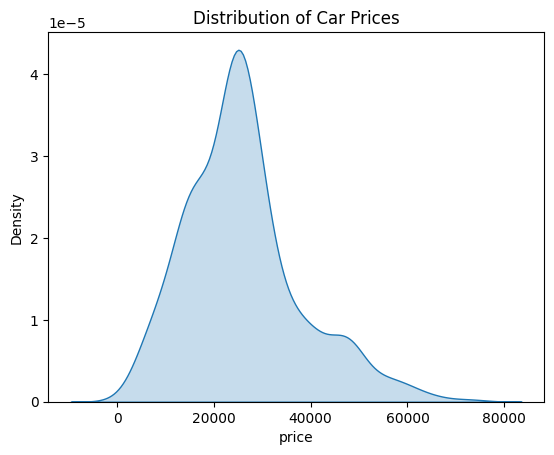

In [2]:
# load data
cars = pd.read_csv('USA_cars_datasets.csv')

# clean data
cars = clean_car_data(cars)

# ordinal encode color and region
cars['color'] = cars.color.apply(lambda x: 0 if x == 'white' else 1 if x == 'black' else 2 if x == 'gray' else 3 if x == 'silver' else 4 if x == 'red' else 5 if x == 'blue' else 6)
cars['region'] = cars.region.apply(lambda x: 0 if x == 'Northeast' else 1 if x == 'Midwest' else 2 if x == 'South' else 3 if x == 'West' else 3)

# peak at target
sns.kdeplot(cars.price, fill = True)
plt.title('Distribution of Car Prices')

# view data
cars.head()

The distribution of are target looks pretty good... slighly right skewed but we should still be able to work with this

## Tree 1

In [3]:
X = cars.drop(columns='price')
y = cars['price']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=21)

In [4]:
# k fold
kf = RepeatedKFold(n_splits=10,n_repeats =5, random_state=42)

# scoring metrics
scoring= ['neg_mean_squared_error','r2','neg_mean_absolute_error']
# hyperparameter
param={'max_depth': np.arange(1,15)}

# decision tree object
reg=DecisionTreeRegressor(random_state=30)

# grid search
search = GridSearchCV(reg, param, scoring=scoring, n_jobs=-1, cv=kf,refit='r2')

# fit our model
model = search.fit(X_train, y_train)

# results from grid search
# mse
mean_sq_err = np.sqrt(abs(model.cv_results_['mean_test_neg_mean_squared_error']))
# r2
r2= model.cv_results_['mean_test_r2']
# mae
mae= abs(model.cv_results_['mean_test_neg_mean_absolute_error'])
# std's for each
SDmse =  model.cv_results_['std_test_neg_mean_squared_error']
SDr2= model.cv_results_['std_test_r2']
SDmae= model.cv_results_['std_test_neg_mean_absolute_error']
# parameter (depth)
depth= np.unique(model.cv_results_['param_max_depth']).data
# combine into df
final_model = pd.DataFrame(list(zip(depth, mean_sq_err, r2,mae, SDmse,SDr2,SDmae)),
               columns =['depth','rmse','r2','mae',"rmseSD",'r2SD','maeSD'])
# let's look
final_model.style.hide(axis="index")

depth,rmse,r2,mae,rmseSD,r2SD,maeSD
1,11529.154978,0.014248,8619.821679,28099014.223110,0.090490,941.861503
2,11110.824872,0.080575,8377.888541,24519676.802722,0.097765,814.826344
3,11314.126909,0.046937,8366.324033,28648823.713673,0.144769,869.997448
4,11257.590648,0.053375,8289.504397,31753990.720245,0.201395,925.895380
5,11236.074362,0.049317,8151.616341,31076553.318564,0.229075,920.078778
6,11331.727246,0.034555,8238.781674,33985161.980722,0.244812,979.289068
7,11589.069318,-0.009212,8322.526140,39550347.807525,0.285954,1109.256726
8,11868.356484,-0.060079,8541.901550,40250647.546901,0.294118,1105.101693
9,12281.991182,-0.136007,8812.834104,40022870.371833,0.298725,1142.180213
10,12717.753209,-0.218039,9141.131713,40973782.305427,0.306822,1081.597935


These are not performing well whatsoever... it's definitely worth it to explore other hyperparameters when creating the tree  

DecisionTreeRegressor(max_depth=np.int64(2), random_state=30)


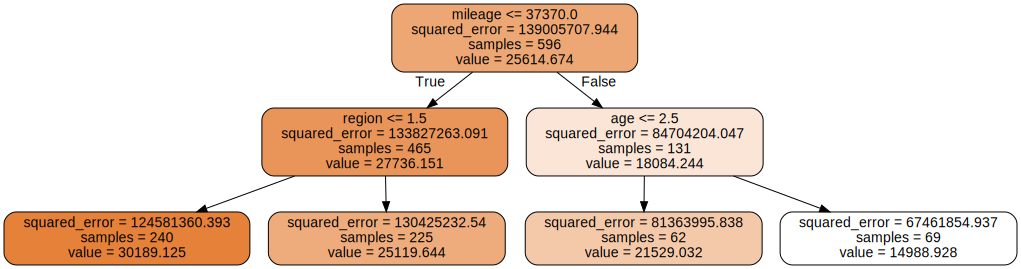

In [5]:
# model that performed the best 
best = search.best_estimator_
print(best)

# view our tree!
dot_data = export_graphviz(best, out_file =None,
               feature_names =X.columns,
               filled=True, 
                rounded=True, ) 
               
graph=graphviz.Source(dot_data)
graph 

The fact that the tree is extremely shallow and has only 4 terminal nodes is concerning. It also explains the model's high rmse and mae

          importance
mileage     0.684862
region      0.214668
age         0.100470
color       0.000000
is_f-150    0.000000
Axes(0.125,0.11;0.775x0.77)


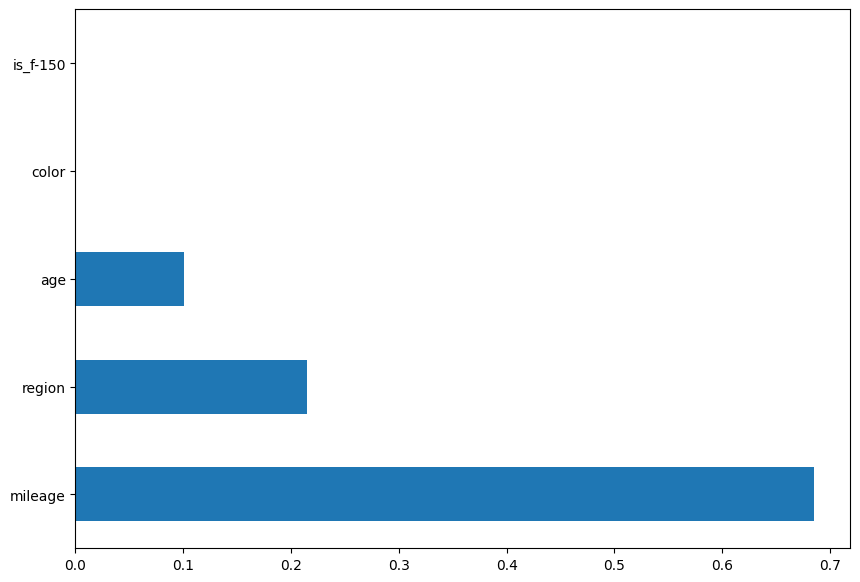

In [6]:
# let's look variable importance
varimp=pd.DataFrame(best.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False)
print(varimp)
# graph
plt.figure(figsize=(10,7))
print(varimp.importance.nlargest(7).plot(kind='barh'))

color and is_f-150 aren't even considered. Maybe they are still valuable and aren't being used because the tree has a depth of 2?

RMSE: 12698.4793
R²: 0.0004
MAE: 9354.3122


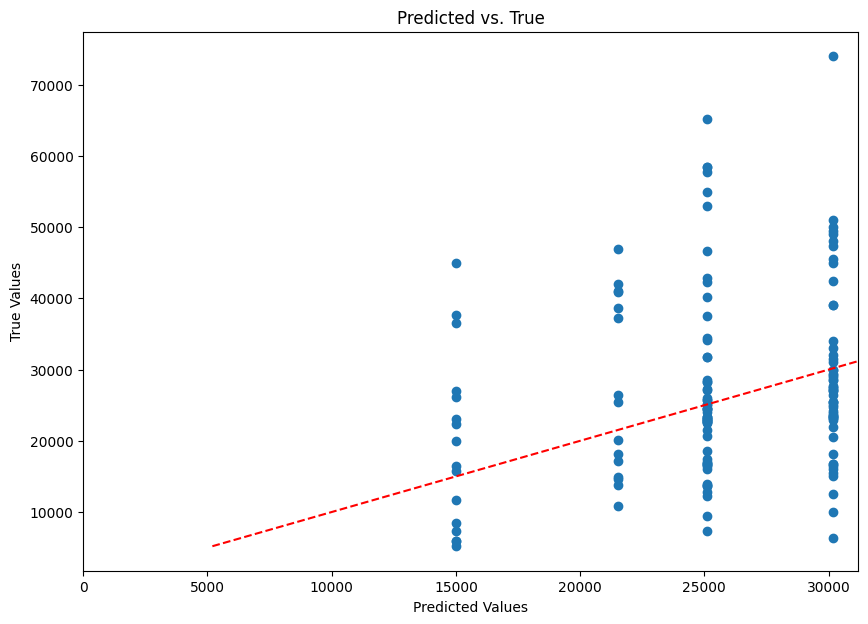

In [7]:
# let's predict on our test data
# I'm expecting the results to be pretty awful given there aren't many values our predctions can have

# fit our test data
predictions = best.predict(X_test)

# find some metrics on data
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse:.4f}")
r2 = r2_score(y_test, predictions)
print(f"R²: {r2:.4f}")
mae = mean_absolute_error(y_test, predictions)
print(f"MAE: {mae:.4f}")

# plot predicted vs true
plt.figure(figsize=(10,7))
plt.scatter(x = predictions, y = y_test)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Predicted vs. True')
min_val = min(min(predictions), min(y_test))
max_val = max(max(predictions), max(y_test))
plt.xlim([0,max(predictions)+1000])
plt.plot([min_val, max_val], [min_val, max_val], 'r--') # y = x line - ideally all values would be on or near this line
plt.show()

As shown above, this model is really struggling to predict car price and establishing barely any relation between price and our variables. Let's try using a different hyperparameter to see if that helps

## Tree 2

In [8]:
# k fold
kf = RepeatedKFold(n_splits=10,n_repeats =5, random_state=42)

# scoring metrics
scoring= ['neg_mean_squared_error','r2','neg_mean_absolute_error']
# hyperparameter
param={'min_samples_leaf': np.arange(10,31)}

# decision tree object
reg=DecisionTreeRegressor(random_state=30)

# grid search
search = GridSearchCV(reg, param, scoring=scoring, n_jobs=-1, cv=kf,refit='r2')

# fit our model
model = search.fit(X_train, y_train)

# results from grid search
# mse
mean_sq_err = np.sqrt(abs(model.cv_results_['mean_test_neg_mean_squared_error']))
# r2
r2= model.cv_results_['mean_test_r2']
# mae
mae= abs(model.cv_results_['mean_test_neg_mean_absolute_error'])
# std's for each
SDmse =  model.cv_results_['std_test_neg_mean_squared_error']
SDr2= model.cv_results_['std_test_r2']
SDmae= model.cv_results_['std_test_neg_mean_absolute_error']
# parameter (min_samples_leaf)
min_samples_leaf= np.unique(model.cv_results_['param_min_samples_leaf']).data
# combine into df
final_model = pd.DataFrame(list(zip(min_samples_leaf, mean_sq_err, r2,mae, SDmse,SDr2,SDmae)),
               columns =['min_samples_leaf','rmse','r2','mae',"rmseSD",'r2SD','maeSD'])
# let's look
final_model.style.hide(axis="index")

min_samples_leaf,rmse,r2,mae,rmseSD,r2SD,maeSD
10,11187.664958,0.056855,8309.302694,27837923.899206,0.207962,962.831338
11,11186.512883,0.057522,8335.728485,26984607.068677,0.194944,948.719373
12,11106.200230,0.072726,8275.689493,26756008.738967,0.183819,966.273025
13,11075.720002,0.077644,8273.398628,27280102.883846,0.186937,956.173050
14,11071.721463,0.077259,8287.221668,25965719.473069,0.182315,928.311757
15,11043.320445,0.080890,8292.319046,24266551.396596,0.173304,877.826856
16,10983.082859,0.092119,8239.573028,24438001.114731,0.167469,897.192441
17,10963.559097,0.096101,8212.268750,24350098.728699,0.160495,868.992342
18,10956.924050,0.097862,8210.133288,24938175.935383,0.163595,863.500592
19,10949.440689,0.098257,8213.613118,25125894.183591,0.169804,873.360159


Looks like 26 min_samples_leaf performs the best. Using min_samples_leaf as our hyperparamter has a slightly improved performance compared to depth

DecisionTreeRegressor(min_samples_leaf=np.int64(26), random_state=30)


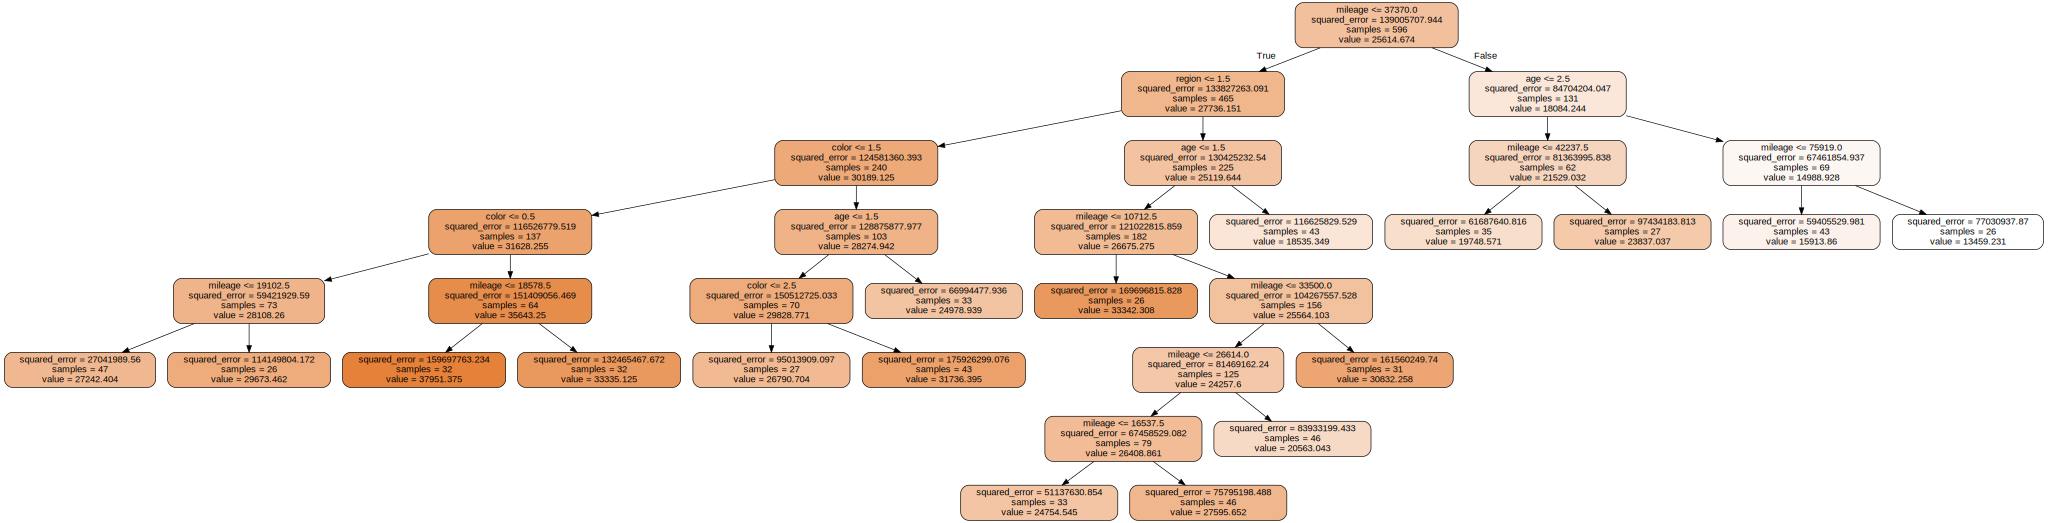

In [9]:
# model that performed the best 
best = search.best_estimator_
print(best)

# view our tree!
dot_data = export_graphviz(best, out_file =None,
               feature_names =X.columns,
               filled=True, 
                rounded=True, ) 
               
graph=graphviz.Source(dot_data)
graph

Our tree already looks more promising. Now that our tree doesn't have a depth of 2 and there are more than 4 terminal nodes, hopefully the model can come up with more nuanced predictions

          importance
mileage     0.576096
age         0.175469
color       0.124602
region      0.123833
is_f-150    0.000000
Axes(0.125,0.11;0.775x0.77)


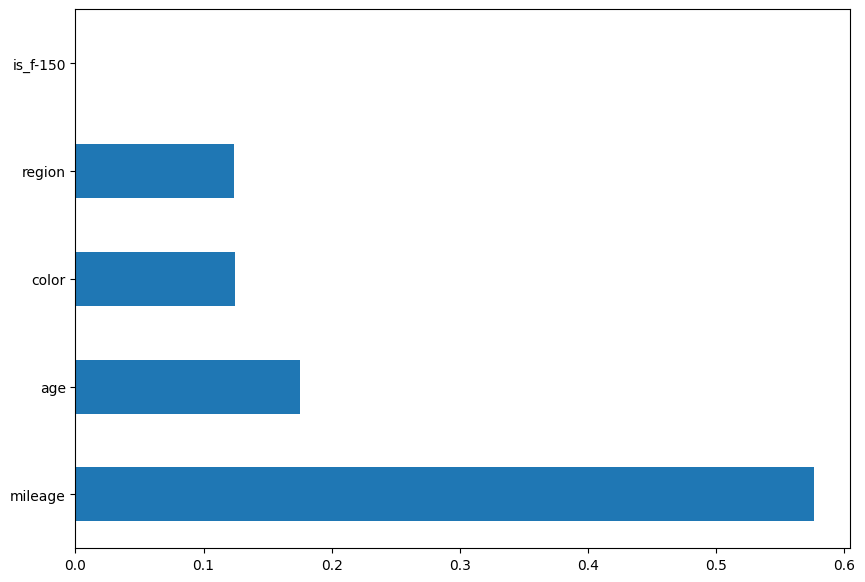

In [10]:
# let's look variable importance
varimp=pd.DataFrame(best.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False)
print(varimp)
# graph
plt.figure(figsize=(10,7))
print(varimp.importance.nlargest(7).plot(kind='barh'))

It's also nice to see that region is of importance- it continues to look like changing our hyperparameter was a good choice

RMSE: 12468.9085
R²: 0.0362
MAE: 9331.2740


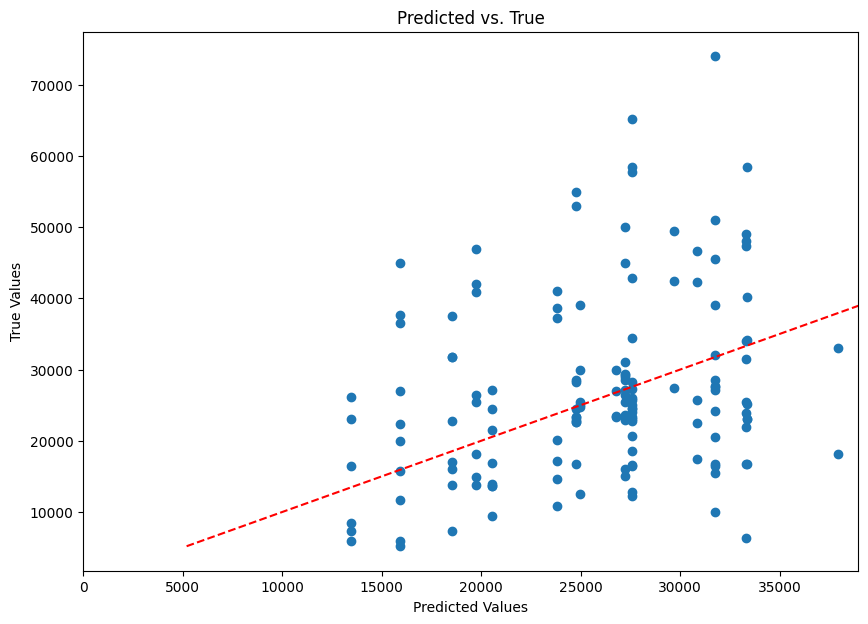

In [11]:
# let's predict on our test data
# I'm expecting the results to be pretty awful given there aren't many values our predctions can have

# fit our test data
predictions = best.predict(X_test)

# find some metrics on data
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse:.4f}")
r2 = r2_score(y_test, predictions)
print(f"R²: {r2:.4f}")
mae = mean_absolute_error(y_test, predictions)
print(f"MAE: {mae:.4f}")

# plot predicted vs true
plt.figure(figsize=(10,7))
plt.scatter(x = predictions, y = y_test)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Predicted vs. True')
min_val = min(min(predictions), min(y_test))
max_val = max(max(predictions), max(y_test))
plt.xlim([0,max(predictions)+1000])
plt.plot([min_val, max_val], [min_val, max_val], 'r--') # y = x line - ideally all values would be on or near this line
plt.show()

Our model's performance is still quite limited, but it shows some improvement over our first attempt. The initial model could only predict four distinct price points, all of which hovered close to the average car price. In contrast, this model produces a wider range of predictions that deviate more from the mean, and it achieves slightly better RMSE and MAE scores.

That said, the model remains weak overall and nearly impossible to use accurately. It fails to accurately predict prices at the high and low ends of the spectrum, performing just okay only for mid-range values near the average.

A regression tree could have been more effective if we had access to more data and a broader set of variables. As it stands, the limited variables and dataset constrain both models leading to coarse predictions that fail to reflect the true variability in car prices.